<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/research_MovieBowl_simpleLGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install japanize_matplotlib

     |████████████████████████████████| 4.1MB 8.8MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120193 sha256=608d906d513f325ef200eb2fc56bd30b098c1326a3dfd04a0082fb682c212b6c
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [ ]:
!git clone https://github.com/microsoft/LightGBM
!cd LightGBM && mkdir build && cd build && cmake .. && make -j"$(nproc)"
!cd LightGBM/python-package && python setup.py install --precompile

fatal: destination path 'LightGBM' already exists and is not an empty directory.
mkdir: cannot create directory ‘build’: File exists
running install
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
running egg_info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writing requirements to lightgbm.egg-info/requires.txt
writing top-level names to lightgbm.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
no previously-included directories found matching 'build'
writing manifest file 'lightgbm.egg-info/SOURCES.txt'
running install_lib
INFO:LightGBM:Installing lib_lightgbm from: ['../lib_lightgbm.so']
running install_egg_info
removing '/usr/local/lib/python3.6/dist-packages/lightgbm-3.0.0.99-py3.6.egg-info' (and everything under it)
Copying lightgbm.egg-info to /usr/local/lib/pyt

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import lightgbm as lgb
import gc 
import numpy as np
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

#評価
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#混同行列
from sklearn.metrics import confusion_matrix 

import pandas as pd 
import matplotlib.pyplot as plt 
import japanize_matplotlib
%matplotlib inline  

import seaborn as sns
import warnings

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [ ]:
path = "/content/drive/My Drive/movie_research/review_csv/tokenized_1006.csv"

In [ ]:
data = pd.read_csv(path)
data.head()

,tokenize,score,kfold
0,ｽﾄｰﾘｰ 面白い 王道 感じ 宗教 力 強い 感ずる 神 信ずる こと 言う 話 理解 出...,4.0,0
1,0 dx ﾌﾟﾛﾓｰｼｮﾝ 映画 思う 極度 0 dx 適する 映像 世界 伝わる ﾋﾞｼﾞ...,3.0,0
2,評価 悪い 見掛ける 面白い les twins 出る 知る 最初 ｺﾛﾝﾋﾞｱ 女神 ﾆﾔ...,4.0,0
3,0 nhk bs ﾌﾟﾚﾐｱﾑ 鑑賞 ｴﾝﾃﾞｨﾝｸﾞ 歌唱 ng ｼｰﾝ,3.0,0
4,情報 量 割 説明 少ない sf 映画 未来 映画 言う ｱｰﾉﾙﾄﾞｼｭﾜﾙﾂｪﾈｯｶﾞｰ...,2.0,0


In [ ]:
data.shape

(179797, 3)

In [ ]:
num = int(len(data)/10)
print(num)
data1 = data.iloc[:num,:]
#data2 = data.iloc[num:,:]
#df2 = pipeline(data2)
print(data.shape, data1.shape)

17979
(179797, 3) (17979, 3)


In [ ]:
#data1のみを使う 観測によると20000行以下でないと次の処理でクラッシュする
tfidf = TfidfVectorizer()
tfidf_df = tfidf.fit_transform(data1["tokenize"])
tfidf_df = pd.DataFrame(tfidf_df.toarray(), columns=tfidf.get_feature_names(), dtype="float16")

use_cols = []
thld_q90 = np.percentile(tfidf_df.std().values, 90)
for col in tfidf_df.columns:
    if thld_q90 < tfidf_df[col].std():
        use_cols.append(col)
          
tfidf_df = tfidf_df[use_cols]   
tfidf_cols = {col:col+'_tfidf' for col in tfidf_df.columns}
tfidf_df = tfidf_df.rename(columns=tfidf_cols) 

In [ ]:
tfidf_df

,00_tfidf,000_tfidf,0000_tfidf,ai_tfidf,akira_tfidf,all_tfidf,amazon_tfidf,and_tfidf,back_tfidf,bd_tfidf,be_tfidf,bgm_tfidf,bluray_tfidf,boss_tfidf,bs_tfidf,bttf_tfidf,cg_tfidf,cm_tfidf,dc_tfidf,dna_tfidf,dvd_tfidf,dx_tfidf,ed_tfidf,et_tfidf,future_tfidf,good_tfidf,hal_tfidf,her_tfidf,hulu_tfidf,imax_tfidf,in_tfidf,is_tfidf,it_tfidf,jj_tfidf,kaiju_tfidf,love_tfidf,mad_tfidf,marvel_tfidf,max_tfidf,mcu_tfidf,...,ﾘﾌﾞｰﾄ_tfidf,ﾘﾌﾟﾘｰ_tfidf,ﾘﾒｲｸ_tfidf,ﾘﾝｸ_tfidf,ﾘﾝﾀﾞ_tfidf,ﾘﾝﾀﾞﾊﾐﾙﾄﾝ_tfidf,ﾙｰｼｰ_tfidf,ﾙｰﾌﾟ_tfidf,ﾙｰﾙ_tfidf,ﾙｲｰｽﾞ_tfidf,ﾚｰｽ_tfidf,ﾚｼﾞｪﾝﾄﾞ_tfidf,ﾚﾄﾛ_tfidf,ﾚﾄﾛｹﾞｰﾑ_tfidf,ﾚﾋﾞｭｰ_tfidf,ﾚﾌﾟﾘｶﾝﾄ_tfidf,ﾚﾍﾞﾙ_tfidf,ﾚﾝﾀﾙ_tfidf,ﾛｯｶｰ_tfidf,ﾛｰ_tfidf,ﾛｰﾄﾞｼｮｰ_tfidf,ﾛｲ_tfidf,ﾛｷ_tfidf,ﾛｹｯﾄ_tfidf,ﾛｼｱ_tfidf,ﾛﾊﾞｰﾄｾﾞﾒｷｽ_tfidf,ﾛﾋﾞﾝｳｨﾘｱﾑｽﾞ_tfidf,ﾛﾎﾞ_tfidf,ﾛﾎﾞｯﾄ_tfidf,ﾛﾎﾞｯﾄｱｸｼｮﾝ_tfidf,ﾛﾎﾞｺｯﾌﾟ_tfidf,ﾛﾎﾞｺｯﾌﾟｼﾘｰｽﾞ_tfidf,ﾛﾏﾝ_tfidf,ﾜｰﾙﾄﾞ_tfidf,ﾜｶﾝﾀﾞ_tfidf,ﾜｶﾝﾀﾞﾌｫｰｴﾊﾞｰ_tfidf,ﾜｸﾜｸ_tfidf,ﾜｸﾜｸﾄﾞｷﾄﾞｷ_tfidf,ﾜﾄﾆｰ_tfidf,ﾜﾝ_tfidf
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.495117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.370117,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.288086,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17977,0.0,0.0,0.0,0.0,0.0

In [ ]:
def class_label(score):
  if score==5.0:
    return 0
  elif score==4.5:
    return 1
  elif score==4.0:
    return 2    
  elif score==3.5:
    return 3
  elif score==3.0:
    return 4
  elif score==2.5:
    return 5
  elif score==2.0:
    return 6
  elif score==1.5:
    return 7
  elif score==1.0:
    return 8

In [ ]:
data1.score.value_counts()

4.0    5824
3.5    4599
4.5    2432
3.0    2270
5.0    1569
2.5     675
2.0     372
1.0     122
1.5     116
Name: score, dtype: int64

In [ ]:
data1["class"] = data1["score"].apply(class_label)
y = data1["class"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_X, valid_X, train_y, valid_y=train_test_split(tfidf_df, y, test_size=0.3,random_state=42)

In [ ]:
from sklearn import metrics

calc_f1 = lambda y, p: metrics.f1_score(y, p.argmax(axis=1), average='macro')

def macro_f1(pred: np.array, data: lgb.Dataset):
    y = data.get_label()
    pred = pred.reshape(-1, len(y)).T  # -> (N, num_class)

    f1 = calc_f1(y, pred)
    return 'macro_f1', f1, True

In [ ]:
y.value_counts()

2    5824
3    4599
1    2432
4    2270
0    1569
5     675
6     372
8     122
7     116
Name: class, dtype: int64

In [ ]:
# 適当なので各自チューニング
params = {
    'objective': 'multiclass',
    'metric': 'custom',
    'num_class':9,
    'learning_rate': 0.005,
    'max_depth': -1,
    'num_leaves': 30,
    'max_bin': 31,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'nthread': -1,
    'bagging_freq': 1,
    'verbose': -1,
    'seed': 1,
    }

In [ ]:
weight = 1 / pd.DataFrame(train_y).reset_index().groupby('class').count().values
weight = weight[train_y].ravel()
weight /= weight.sum()

In [ ]:
dtrain = lgb.Dataset(train_X, train_y, weight=weight)

In [ ]:
cvbooster = lgb.cv(params, dtrain, return_cvbooster=True, stratified=False, 
        num_boost_round=9999, verbose_eval=100, early_stopping_rounds=200,
        feval=macro_f1,
        #nfold=5
        )['cvbooster']

[100]	cv_agg's macro_f1: 0.131302 + 0.00575823
[200]	cv_agg's macro_f1: 0.136872 + 0.00674812
[300]	cv_agg's macro_f1: 0.14171 + 0.00572177
[400]	cv_agg's macro_f1: 0.145423 + 0.00578193
[500]	cv_agg's macro_f1: 0.146265 + 0.00430148
[600]	cv_agg's macro_f1: 0.148978 + 0.00386865
[700]	cv_agg's macro_f1: 0.149416 + 0.00366004
[800]	cv_agg's macro_f1: 0.150382 + 0.00401338
[900]	cv_agg's macro_f1: 0.151215 + 0.0042984
[1000]	cv_agg's macro_f1: 0.151325 + 0.00315393
[1100]	cv_agg's macro_f1: 0.152121 + 0.00405346
[1200]	cv_agg's macro_f1: 0.151829 + 0.00472815
[1300]	cv_agg's macro_f1: 0.1528 + 0.00360966
[1400]	cv_agg's macro_f1: 0.152728 + 0.0042815
[1500]	cv_agg's macro_f1: 0.153305 + 0.00491003
[1600]	cv_agg's macro_f1: 0.153782 + 0.00353612
[1700]	cv_agg's macro_f1: 0.153207 + 0.00302501


In [ ]:
raw_importances = cvbooster.feature_importance(importance_type='gain')
feature_name = cvbooster.boosters[0].feature_name()
importance_df = pd.DataFrame(data=raw_importances, columns=feature_name)

In [ ]:
importance_df

,00_tfidf,000_tfidf,0000_tfidf,ai_tfidf,akira_tfidf,all_tfidf,amazon_tfidf,and_tfidf,back_tfidf,bd_tfidf,be_tfidf,bgm_tfidf,bluray_tfidf,boss_tfidf,bs_tfidf,bttf_tfidf,cg_tfidf,cm_tfidf,dc_tfidf,dna_tfidf,dvd_tfidf,dx_tfidf,ed_tfidf,et_tfidf,future_tfidf,good_tfidf,hal_tfidf,her_tfidf,hulu_tfidf,imax_tfidf,in_tfidf,is_tfidf,it_tfidf,jj_tfidf,kaiju_tfidf,love_tfidf,mad_tfidf,marvel_tfidf,max_tfidf,mcu_tfidf,...,ﾘﾌﾞｰﾄ_tfidf,ﾘﾌﾟﾘｰ_tfidf,ﾘﾒｲｸ_tfidf,ﾘﾝｸ_tfidf,ﾘﾝﾀﾞ_tfidf,ﾘﾝﾀﾞﾊﾐﾙﾄﾝ_tfidf,ﾙｰｼｰ_tfidf,ﾙｰﾌﾟ_tfidf,ﾙｰﾙ_tfidf,ﾙｲｰｽﾞ_tfidf,ﾚｰｽ_tfidf,ﾚｼﾞｪﾝﾄﾞ_tfidf,ﾚﾄﾛ_tfidf,ﾚﾄﾛｹﾞｰﾑ_tfidf,ﾚﾋﾞｭｰ_tfidf,ﾚﾌﾟﾘｶﾝﾄ_tfidf,ﾚﾍﾞﾙ_tfidf,ﾚﾝﾀﾙ_tfidf,ﾛｯｶｰ_tfidf,ﾛｰ_tfidf,ﾛｰﾄﾞｼｮｰ_tfidf,ﾛｲ_tfidf,ﾛｷ_tfidf,ﾛｹｯﾄ_tfidf,ﾛｼｱ_tfidf,ﾛﾊﾞｰﾄｾﾞﾒｷｽ_tfidf,ﾛﾋﾞﾝｳｨﾘｱﾑｽﾞ_tfidf,ﾛﾎﾞ_tfidf,ﾛﾎﾞｯﾄ_tfidf,ﾛﾎﾞｯﾄｱｸｼｮﾝ_tfidf,ﾛﾎﾞｺｯﾌﾟ_tfidf,ﾛﾎﾞｺｯﾌﾟｼﾘｰｽﾞ_tfidf,ﾛﾏﾝ_tfidf,ﾜｰﾙﾄﾞ_tfidf,ﾜｶﾝﾀﾞ_tfidf,ﾜｶﾝﾀﾞﾌｫｰｴﾊﾞｰ_tfidf,ﾜｸﾜｸ_tfidf,ﾜｸﾜｸﾄﾞｷﾄﾞｷ_tfidf,ﾜﾄﾆｰ_tfidf,ﾜﾝ_tfidf
0,0.355853,0.000000,0.0,0.013026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.406476,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.081059,0.0,0.516100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.318122,0.0,0.0,0.0
1,0.161303,0.001604,0.0,0.007085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.743365,0.0,0.0,0.0,0.008314,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165645,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.019533,0.0,0.010663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.246351,0.0,0.0,0.0
2,0.185907,0.004767,0.0,0.009347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431280,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003196,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.218632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242973,0.0,0.0,0.0
3,0.292268,0.004921,0.0,0.027647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.624970,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.013393,0.0,0.007110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.220283,0.0,0.0,0.0
4,0.376259,0.011033,0.0,0.003832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.676270,0.0,0.0,0.0,0.003101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123264,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.465418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.316028,0.0,0.0,0.0


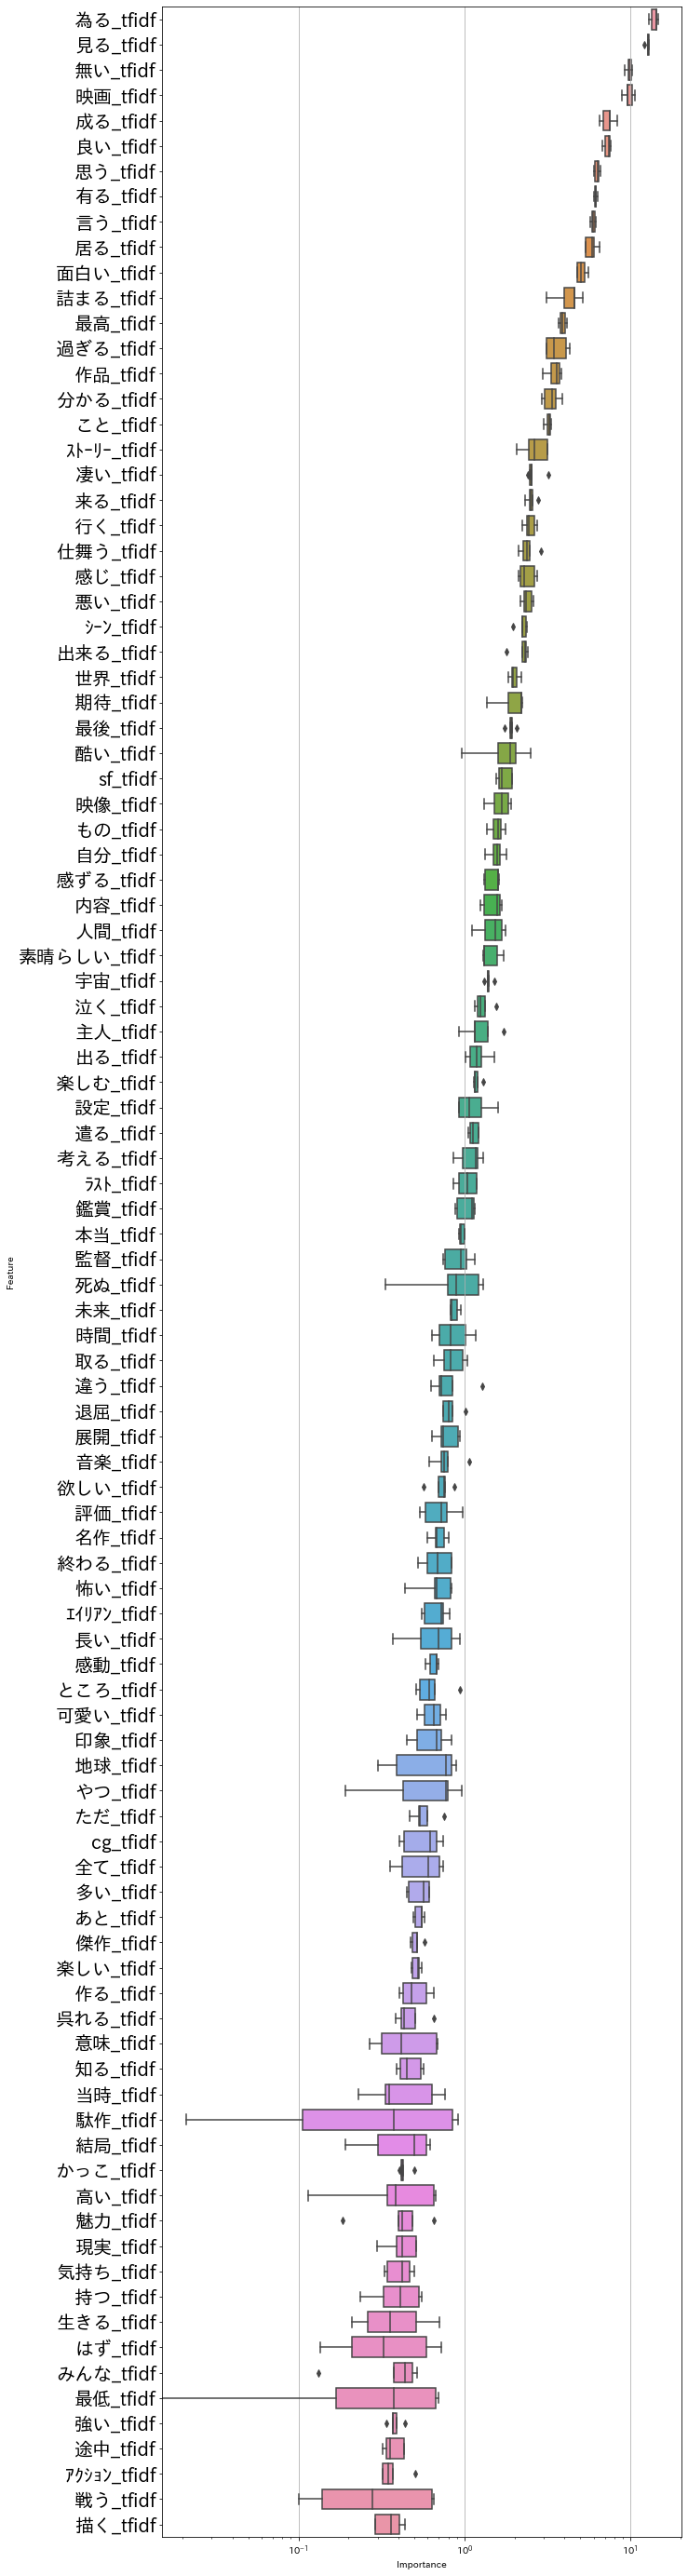

In [ ]:
# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロットする
PLOT_TOP_N = 100
plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
_, ax = plt.subplots(figsize=(10, 50))
ax.grid()
ax.set_xscale('log')
ax.set_ylabel('Feature')
plt.yticks(fontsize=20)
ax.set_xlabel('Importance')
sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
plt.show()

In [ ]:
data[data["tokenize"] == 'かっこ']

,tokenize,score,kfold
71237,かっこ,4.0,1


In [ ]:
prepro_df=pd.read_csv('/content/drive/My Drive/movie_research/review_csv/tokenized_1006.csv')

In [ ]:
prepro_df[prepro_df["tokenize"] == 'かっこ']

,tokenize,score,kfold
71237,かっこ,4.0,1


In [ ]:
origin_df=pd.read_csv('/content/drive/My Drive/movie_research/review_csv/SF_data.csv')

In [ ]:
pred = cvbooster.predict(valid_X)
predict = np.stack(pred).mean(axis=0)

In [ ]:
predict = predict.argmax(axis=1)

In [ ]:
cf_matrix = confusion_matrix(y_true=valid_y, y_pred=predict)

In [ ]:
cf_matrix

array([[166, 117,  69,  46,  38,  17,   7,   3,   9],
       [177, 163, 136, 101,  57,  34,  25,   7,  11],
       [278, 342, 351, 333, 224,  93,  70,   6,  22],
       [113, 172, 282, 356, 284, 132,  70,   5,  30],
       [ 38,  66,  99, 146, 183,  87,  48,   5,   8],
       [ 14,  14,  16,  50,  51,  21,  20,   5,   3],
       [  6,   6,  10,  21,  27,  15,   8,   1,   1],
       [  5,   2,   3,  10,   9,   7,   3,   0,   0],
       [  2,   1,   3,  15,   9,   4,   3,   0,   3]])

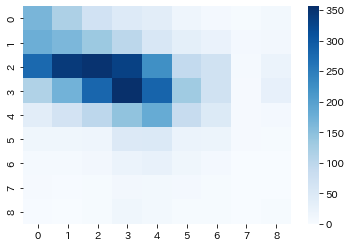

In [ ]:
sns.heatmap(cf_matrix,label=labels ,cmap='Blues')

In [ ]:
predict = pd.DataFrame(predict,columns={'predict'})

In [ ]:
valid_y = pd.DataFrame(valid_y,columns={'valid_y'})

In [ ]:
valid_X.shape, valid_y.shape,predict.shape

((5394, 2860), (0, 1), (5394, 1))

In [ ]:
pd.concat([valid_X, valid_y,predict],axis=1)

,00_tfidf,000_tfidf,0000_tfidf,ai_tfidf,akira_tfidf,all_tfidf,amazon_tfidf,and_tfidf,back_tfidf,bd_tfidf,be_tfidf,bgm_tfidf,bluray_tfidf,boss_tfidf,bs_tfidf,bttf_tfidf,cg_tfidf,cm_tfidf,dc_tfidf,dna_tfidf,dvd_tfidf,dx_tfidf,ed_tfidf,et_tfidf,future_tfidf,good_tfidf,hal_tfidf,her_tfidf,hulu_tfidf,imax_tfidf,in_tfidf,is_tfidf,it_tfidf,jj_tfidf,kaiju_tfidf,love_tfidf,mad_tfidf,marvel_tfidf,max_tfidf,mcu_tfidf,...,ﾘﾒｲｸ_tfidf,ﾘﾝｸ_tfidf,ﾘﾝﾀﾞ_tfidf,ﾘﾝﾀﾞﾊﾐﾙﾄﾝ_tfidf,ﾙｰｼｰ_tfidf,ﾙｰﾌﾟ_tfidf,ﾙｰﾙ_tfidf,ﾙｲｰｽﾞ_tfidf,ﾚｰｽ_tfidf,ﾚｼﾞｪﾝﾄﾞ_tfidf,ﾚﾄﾛ_tfidf,ﾚﾄﾛｹﾞｰﾑ_tfidf,ﾚﾋﾞｭｰ_tfidf,ﾚﾌﾟﾘｶﾝﾄ_tfidf,ﾚﾍﾞﾙ_tfidf,ﾚﾝﾀﾙ_tfidf,ﾛｯｶｰ_tfidf,ﾛｰ_tfidf,ﾛｰﾄﾞｼｮｰ_tfidf,ﾛｲ_tfidf,ﾛｷ_tfidf,ﾛｹｯﾄ_tfidf,ﾛｼｱ_tfidf,ﾛﾊﾞｰﾄｾﾞﾒｷｽ_tfidf,ﾛﾋﾞﾝｳｨﾘｱﾑｽﾞ_tfidf,ﾛﾎﾞ_tfidf,ﾛﾎﾞｯﾄ_tfidf,ﾛﾎﾞｯﾄｱｸｼｮﾝ_tfidf,ﾛﾎﾞｺｯﾌﾟ_tfidf,ﾛﾎﾞｺｯﾌﾟｼﾘｰｽﾞ_tfidf,ﾛﾏﾝ_tfidf,ﾜｰﾙﾄﾞ_tfidf,ﾜｶﾝﾀﾞ_tfidf,ﾜｶﾝﾀﾞﾌｫｰｴﾊﾞｰ_tfidf,ﾜｸﾜｸ_tfidf,ﾜｸﾜｸﾄﾞｷﾄﾞｷ_tfidf,ﾜﾄﾆｰ_tfidf,ﾜﾝ_tfidf,class,predict
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.370117,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17953,0.0,0.0,0.0,0.250977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.224121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
17954,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
17967,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,NaN
17975,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('confusion matrix = \n', confusion_matrix(y_true=valid_y, y_pred=predict))
print('accuracy = ', accuracy_score(y_true=valid_y, y_pred=predict))
print('precision = ', precision_score(y_true=valid_y, y_pred=predict,average='macro'))
print('recall = ', recall_score(y_true=valid_y, y_pred=predict,average='macro'))
print('f1 score = ', f1_score(y_true=valid_y, y_pred=predict,average='macro'))

confusion matrix = 
 [[166 117  69  46  38  17   7   3   9]
 [177 163 136 101  57  34  25   7  11]
 [278 342 351 333 224  93  70   6  22]
 [113 172 282 356 284 132  70   5  30]
 [ 38  66  99 146 183  87  48   5   8]
 [ 14  14  16  50  51  21  20   5   3]
 [  6   6  10  21  27  15   8   1   1]
 [  5   2   3  10   9   7   3   0   0]
 [  2   1   3  15   9   4   3   0   3]]
accuracy =  0.23192436040044495
precision =  0.15661214196398643
recall =  0.17425010668147356
f1 score =  0.15623841011454276


In [ ]:
y_score = np.stack(pred).mean(axis=0)

In [ ]:
n_classes = 9 

In [ ]:
valid_y

5954     2
2616     3
4518     3
4400     1
11790    2
        ..
11945    3
17162    4
16020    6
6398     2
11419    0
Name: class, Length: 5394, dtype: int64

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore') 
pd.DataFrame(enc.fit_transform(valid_y).to_array())


ValueError: ignored

In [ ]:
y_test = valid_y.astype('category')

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(valid_y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(valid_y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

ValueError: ignored

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()